In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pump-sensor-data/sensor.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier



In [3]:
# Load the data
df = pd.read_csv('/kaggle/input/pump-sensor-data/sensor.csv')



In [4]:
# Explore
print(df.head())


   Unnamed: 0            timestamp  sensor_00  sensor_01  sensor_02  \
0           0  2018-04-01 00:00:00   2.465394   47.09201    53.2118   
1           1  2018-04-01 00:01:00   2.465394   47.09201    53.2118   
2           2  2018-04-01 00:02:00   2.444734   47.35243    53.2118   
3           3  2018-04-01 00:03:00   2.460474   47.09201    53.1684   
4           4  2018-04-01 00:04:00   2.445718   47.13541    53.2118   

   sensor_03  sensor_04  sensor_05  sensor_06  sensor_07  ...  sensor_43  \
0  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
1  46.310760   634.3750   76.45975   13.41146   16.13136  ...   41.92708   
2  46.397570   638.8889   73.54598   13.32465   16.03733  ...   41.66666   
3  46.397568   628.1250   76.98898   13.31742   16.24711  ...   40.88541   
4  46.397568   636.4583   76.58897   13.35359   16.21094  ...   41.40625   

   sensor_44  sensor_45  sensor_46  sensor_47  sensor_48  sensor_49  \
0  39.641200   65.68287   50.92593  38.194440

In [5]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 55 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      220320 non-null  int64  
 1   timestamp       220320 non-null  object 
 2   sensor_00       210112 non-null  float64
 3   sensor_01       219951 non-null  float64
 4   sensor_02       220301 non-null  float64
 5   sensor_03       220301 non-null  float64
 6   sensor_04       220301 non-null  float64
 7   sensor_05       220301 non-null  float64
 8   sensor_06       215522 non-null  float64
 9   sensor_07       214869 non-null  float64
 10  sensor_08       215213 non-null  float64
 11  sensor_09       215725 non-null  float64
 12  sensor_10       220301 non-null  float64
 13  sensor_11       220301 non-null  float64
 14  sensor_12       220301 non-null  float64
 15  sensor_13       220301 non-null  float64
 16  sensor_14       220299 non-null  float64
 17  sensor_15 

In [6]:
print(df['machine_status'].value_counts())

machine_status
NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: count, dtype: int64


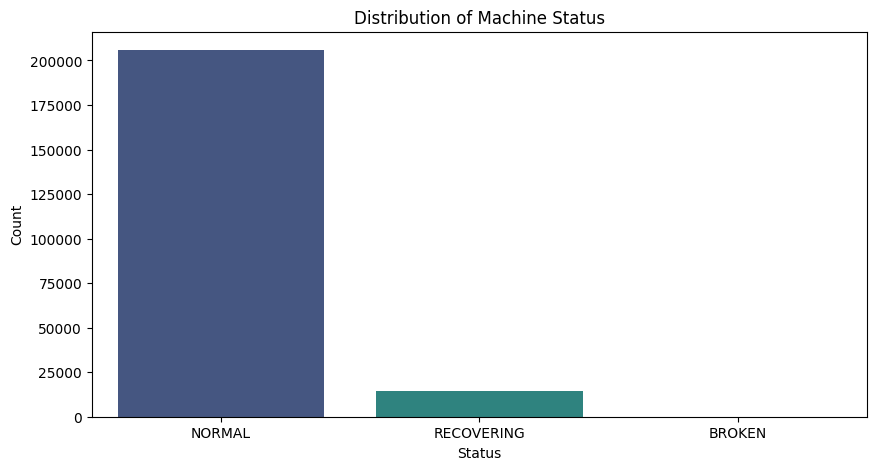

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of machine_status
plt.figure(figsize=(10, 5))
status_counts = df['machine_status'].value_counts()
sns.barplot(x=status_counts.index, y=status_counts.values, palette='viridis')
plt.title("Distribution of Machine Status")
plt.xlabel("Status")
plt.ylabel("Count")
plt.show()

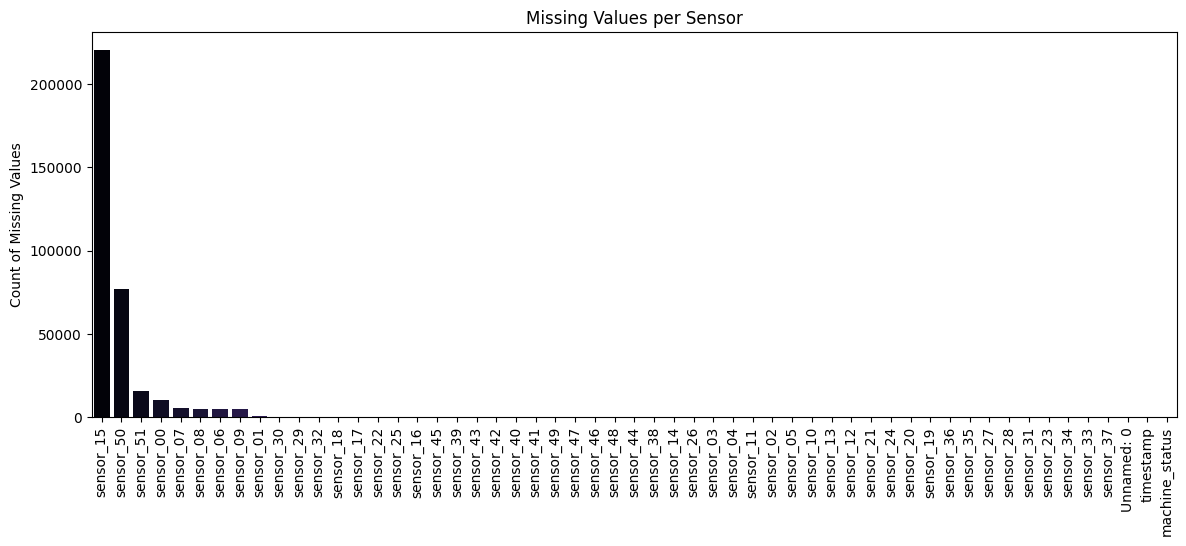

In [8]:
missing = df.isnull().sum().sort_values(ascending=False)

plt.figure(figsize=(14,5))
sns.barplot(x=missing.index, y=missing.values, palette="magma")
plt.xticks(rotation=90)
plt.title("Missing Values per Sensor")
plt.ylabel("Count of Missing Values")
plt.show()


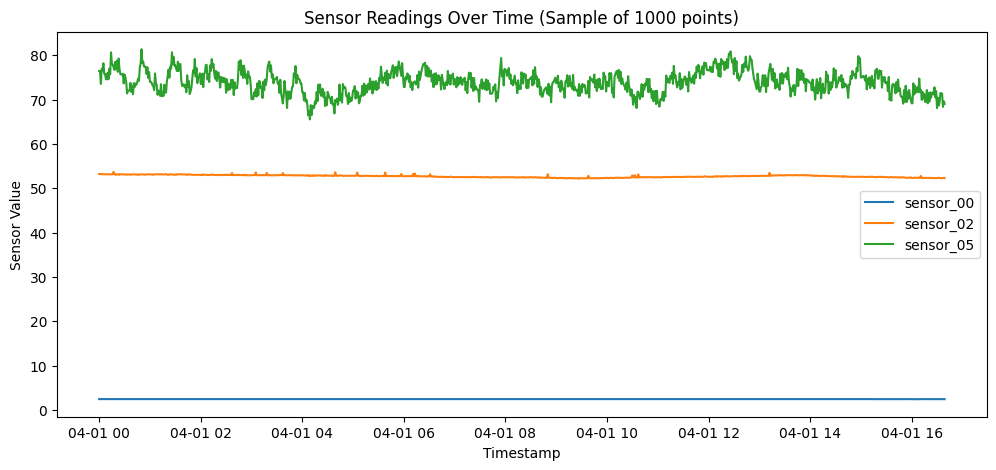

In [9]:
df["timestamp"] = pd.to_datetime(df["timestamp"])  # Ensure datetime

plt.figure(figsize=(12,5))
plt.plot(df["timestamp"][:1000], df["sensor_00"][:1000], label="sensor_00")
plt.plot(df["timestamp"][:1000], df["sensor_02"][:1000], label="sensor_02")
plt.plot(df["timestamp"][:1000], df["sensor_05"][:1000], label="sensor_05")
plt.title("Sensor Readings Over Time (Sample of 1000 points)")
plt.xlabel("Timestamp")
plt.ylabel("Sensor Value")
plt.legend()
plt.show()


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


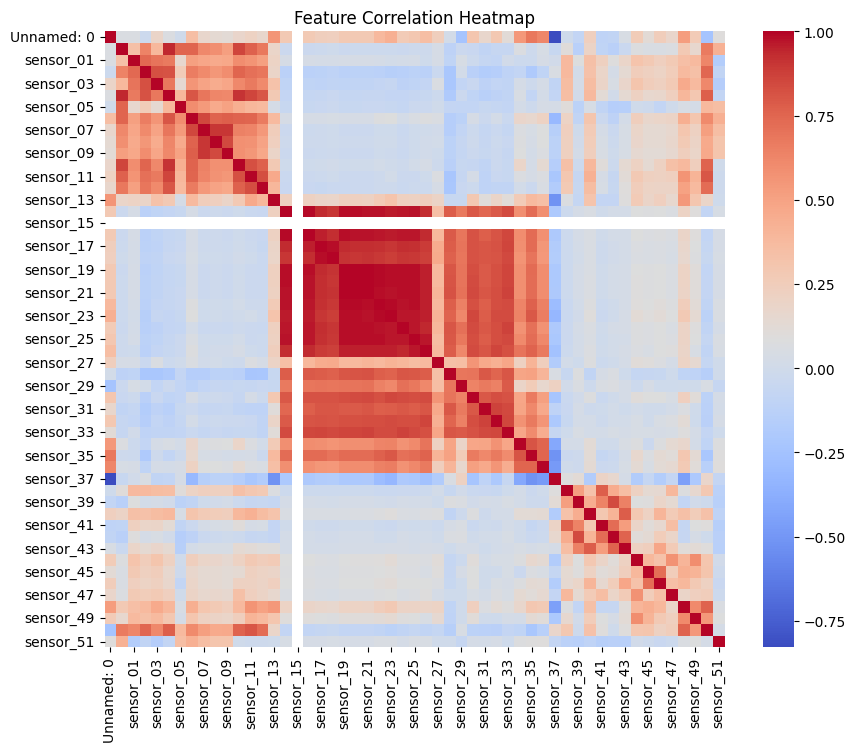

In [10]:
# Step 5: Correlation Heatmap (Numerical Features Only)
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True), annot=False, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

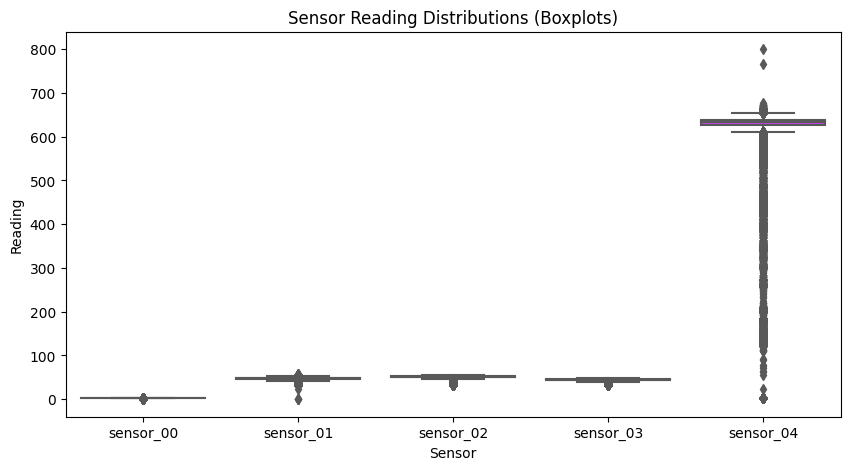

In [11]:
subset = df[["sensor_00", "sensor_01", "sensor_02", "sensor_03", "sensor_04"]].melt(
    var_name="Sensor", value_name="Reading"
)

plt.figure(figsize=(10,5))
sns.boxplot(x="Sensor", y="Reading", data=subset, palette="cool")
plt.title("Sensor Reading Distributions (Boxplots)")
plt.show()


In [12]:
# Drop irrelevant columns (which are more mostly NaN)
df = df.drop(['timestamp', 'sensor_15', 'sensor_50', 'sensor_51'], axis=1, errors='ignore')

df['failure'] = df['machine_status']#.apply(lambda x: 1 if x == 'BROKEN' else 0)

# Fill missing values (median for sensors)
df = df.fillna(df.median(numeric_only=True))

# Split features (X) and target (y)
X = df.drop(['machine_status', 'failure'], axis=1)
y = df['failure']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
model_rf = RandomForestClassifier(class_weight='balanced', random_state=42)
model_rf.fit(X_train, y_train)

# Predictions
y_pred_rf = model_rf.predict(X_test)
y_proba_rf = model_rf.predict_proba(X_test)[:, 1]  # Probabilities for AUC

# Evaluate
# To suppress the warnings and handle zero division explicitly
print(classification_report(y_test, y_pred_rf, zero_division=0))



              precision    recall  f1-score   support

      BROKEN       0.00      0.00      0.00         2
      NORMAL       1.00      1.00      1.00     61804
  RECOVERING       1.00      1.00      1.00      4290

    accuracy                           1.00     66096
   macro avg       0.67      0.67      0.67     66096
weighted avg       1.00      1.00      1.00     66096



In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y  # Critical!
)

In [15]:
pip install --upgrade scikit-learn imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [16]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(
    k_neighbors=1,  # Use only 1 neighbor (minimum possible)
    random_state=42
)
X_res, y_res = smote.fit_resample(X_train, y_train)

In [17]:
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Step 1: Ensure minority has ≥6 samples
ros = RandomOverSampler(sampling_strategy={'BROKEN': 164}, random_state=42)  # Target 6 samples
X_temp, y_temp = ros.fit_resample(X_train, y_train)

# Step 2: Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_res, y_res = smote.fit_resample(X_temp, y_temp)

In [18]:
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.preprocessing import LabelEncoder

# Encode string labels to integers (e.g., 'NORMAL' → 0, 'BROKEN' → 1, etc.)
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
# Check current class distribution
print("Original class counts:", np.bincount(y_train_encoded))  # e.g., [66094, 164]

# Apply SMOTE to balance classes
smote = SMOTE(
    sampling_strategy='auto',  # Balances to majority count (66094)
    k_neighbors=4,             # Default (ensure minority has >5 samples)
    random_state=42
)
X_res, y_res = smote.fit_resample(X_train, y_train)

print("Class distribution after SMOTE:", pd.Series(y_res).value_counts()) # e.g., [66094, 66094]

Original class counts: [     5 144085  10134]
Class distribution after SMOTE: failure
NORMAL        144085
RECOVERING    144085
BROKEN        144085
Name: count, dtype: int64


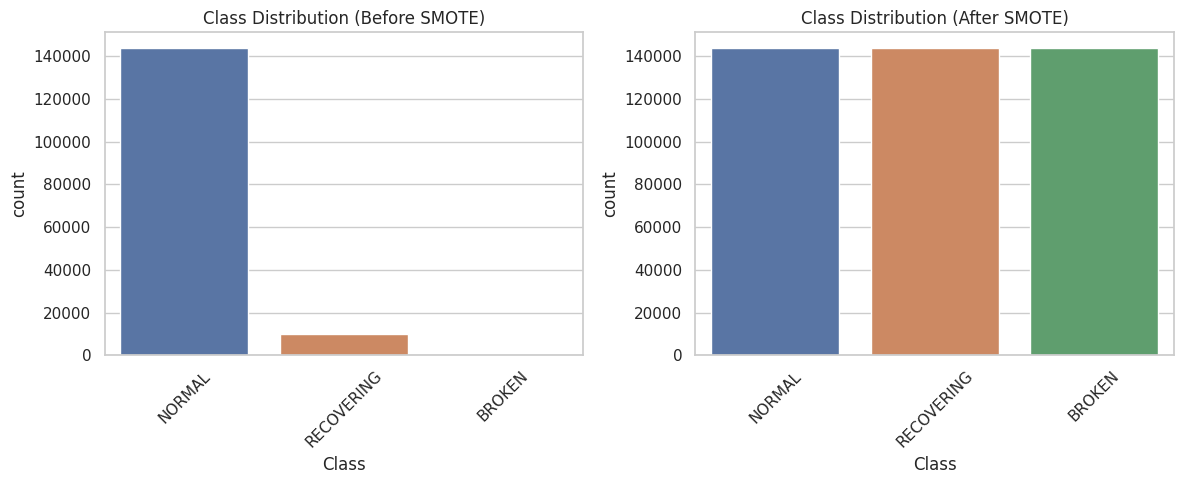

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert to pandas Series for proper handling
y_train_series = pd.Series(y_train)
y_res_series = pd.Series(y_res)

# Set style
sns.set(style="whitegrid")

# Before SMOTE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
ax = sns.countplot(x=y_train_series, order=y_train_series.value_counts().index)
plt.title("Class Distribution (Before SMOTE)")
ax.set_xlabel("Class")  # Explicitly naming x-axis
plt.xticks(rotation=45)

# After SMOTE
plt.subplot(1, 2, 2)
ax = sns.countplot(x=y_res_series, order=y_res_series.value_counts().index)
plt.title("Class Distribution (After SMOTE)")
ax.set_xlabel("Class")  # Explicitly naming x-axis
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [20]:
from sklearn.datasets import make_classification
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

# Step 1: Generate synthetic dataset with 3 classes
X, y = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=3,
    weights=[0.3, 0.5, 0.2],
    random_state=42
)

# Step 2: Encode labels into class names
label_names = ['BROKEN', 'NORMAL', 'RECOVERING']
le = LabelEncoder()
y = le.fit_transform([label_names[i] for i in y])  # convert integers back to named labels then encode

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Step 4: Apply scaling (optional but good practice)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 5: Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Step 6: Train XGBoost model
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)
model.fit(X_train_res, y_train_res)

# Step 7: Predict on test set
y_pred = model.predict(X_test)

# Step 8: Decode labels back to original class names
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

# Step 9: Print classification report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels))



Classification Report:
              precision    recall  f1-score   support

      BROKEN       0.89      0.85      0.87       902
      NORMAL       0.93      0.95      0.94      1494
  RECOVERING       0.86      0.89      0.87       604

    accuracy                           0.90      3000
   macro avg       0.89      0.89      0.89      3000
weighted avg       0.90      0.90      0.90      3000



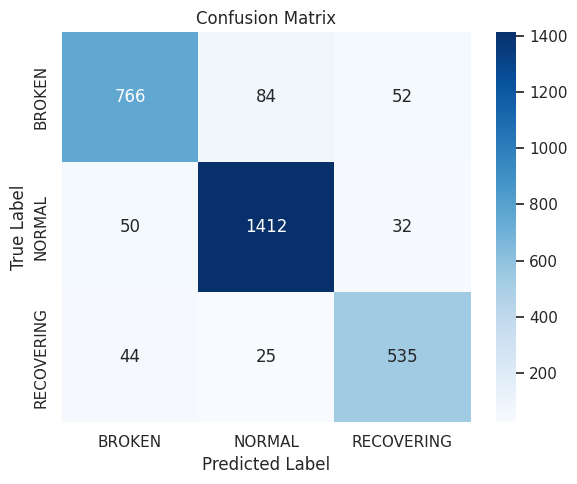

In [21]:
#  Confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=le.classes_)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


Top 10 Feature Importances:
  Feature  Importance
sensor_18    0.109123
sensor_01    0.093318
sensor_03    0.073724
sensor_02    0.072055
sensor_06    0.058188
sensor_16    0.054174
sensor_17    0.053456
sensor_14    0.050670
sensor_09    0.049359
sensor_10    0.043486


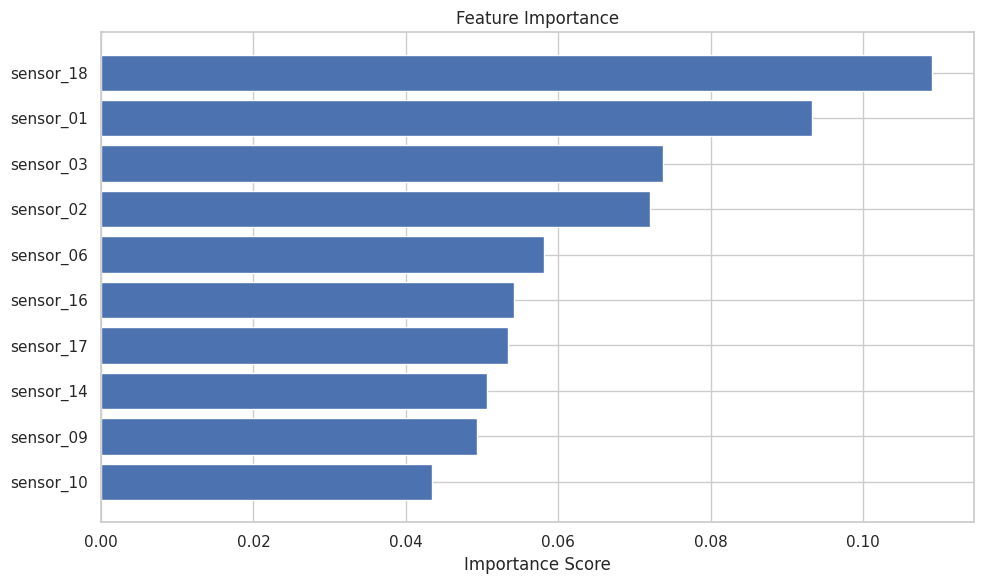

In [22]:
# Feature Importance Analysis
feature_importance = model.feature_importances_

# Create and sort feature importance DataFrame
importance_df = pd.DataFrame({
    'Feature': [f'sensor_{i:02d}' for i in range(len(feature_importance))],
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Display top 10 features
print("Top 10 Feature Importances:")
print(importance_df.head(10).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10))
plt.xlabel('Importance Score')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [23]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

# Step 1: Generate synthetic dataset with 3 classes
X, y = make_classification(
    n_samples=10000,
    n_features=20,
    n_informative=15,
    n_redundant=5,
    n_classes=3,
    weights=[0.3, 0.5, 0.2],
    random_state=42
)

# Step 2: Encode labels into class names
label_names = ['BROKEN', 'NORMAL', 'RECOVERING']
le = LabelEncoder()
y = le.fit_transform([label_names[i] for i in y])

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Step 4: Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 5: Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Step 6: Train Random Forest on resampled data
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    random_state=42
)
model.fit(X_train_res, y_train_res)

# Step 7: Predict on test set
y_pred = model.predict(X_test)

# Step 8: Decode labels
y_test_labels = le.inverse_transform(y_test)
y_pred_labels = le.inverse_transform(y_pred)

# Step 9: Classification Report
print("\nClassification Report:")
print(classification_report(y_test_labels, y_pred_labels))



Classification Report:
              precision    recall  f1-score   support

      BROKEN       0.87      0.83      0.85       902
      NORMAL       0.91      0.95      0.93      1494
  RECOVERING       0.88      0.85      0.86       604

    accuracy                           0.89      3000
   macro avg       0.89      0.87      0.88      3000
weighted avg       0.89      0.89      0.89      3000



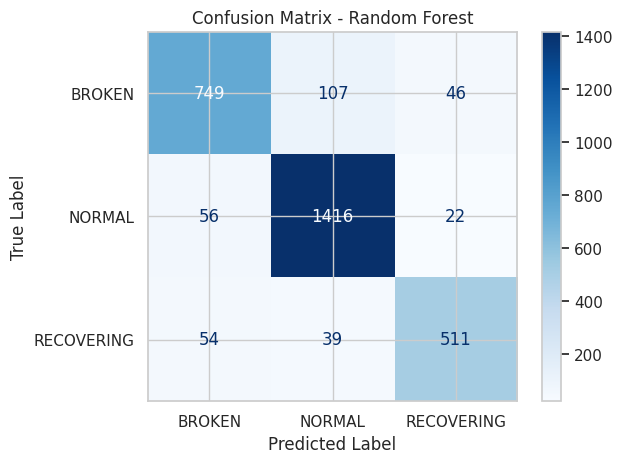

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Step 10: Confusion Matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=label_names)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Top 10 Random Forest Feature Importances:
  Feature  Importance
sensor_18    0.099087
sensor_03    0.076738
sensor_01    0.064272
sensor_16    0.058570
sensor_17    0.055581
sensor_09    0.055506
sensor_14    0.052401
sensor_06    0.052256
sensor_02    0.050652
sensor_05    0.048204


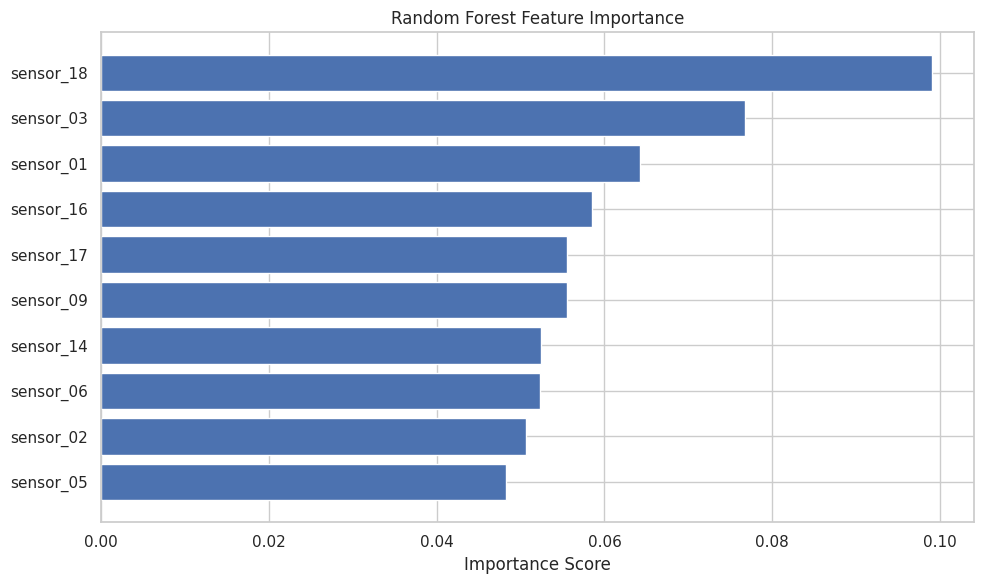

In [34]:
# Random Forest Feature Importance
feature_importance = model.feature_importances_

# Create and sort feature importance DataFrame
importance_df = pd.DataFrame({
    'Feature': [f'sensor_{i:02d}' for i in range(len(feature_importance))],
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

# Display top 10 features
print("Top 10 Random Forest Feature Importances:")
print(importance_df.head(10).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10))
plt.xlabel('Importance Score')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [25]:
from sklearn.svm import SVC

# Initialize SVM with RBF kernel
svm_model = SVC(kernel='rbf', probability=True, random_state=42)

# Train on resampled data
svm_model.fit(X_train_res, y_train_res)

# Predict on test data
y_pred_svm = svm_model.predict(X_test)
y_pred_labels_svm = le.inverse_transform(y_pred_svm)

# Classification report
print("\nSVM Classification Report:")
print(classification_report(y_test_labels, y_pred_labels_svm))



SVM Classification Report:
              precision    recall  f1-score   support

      BROKEN       0.92      0.90      0.91       902
      NORMAL       0.96      0.96      0.96      1494
  RECOVERING       0.91      0.93      0.92       604

    accuracy                           0.94      3000
   macro avg       0.93      0.93      0.93      3000
weighted avg       0.94      0.94      0.94      3000



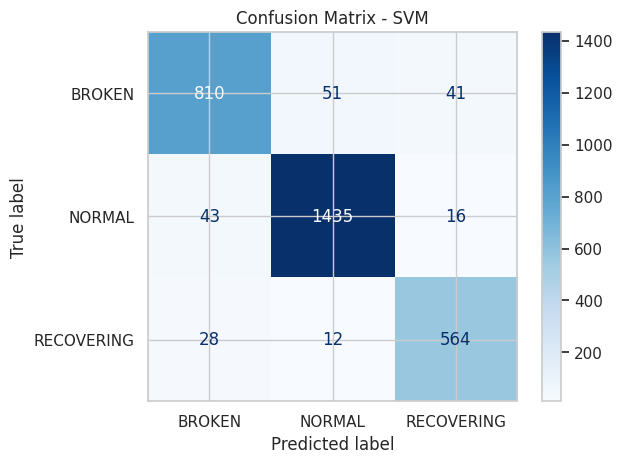

In [26]:
# Replace model-specific predictions accordingly
cm = confusion_matrix(y_test_labels, y_pred_labels_svm, labels=label_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - SVM")
plt.show()


Top 10 SVM Feature Importances:
  Feature  Importance
sensor_18    0.070367
sensor_03    0.069433
sensor_04    0.044433
sensor_06    0.039500
sensor_16    0.037533
sensor_07    0.037133
sensor_17    0.036767
sensor_14    0.035233
sensor_05    0.029467
sensor_10    0.028700


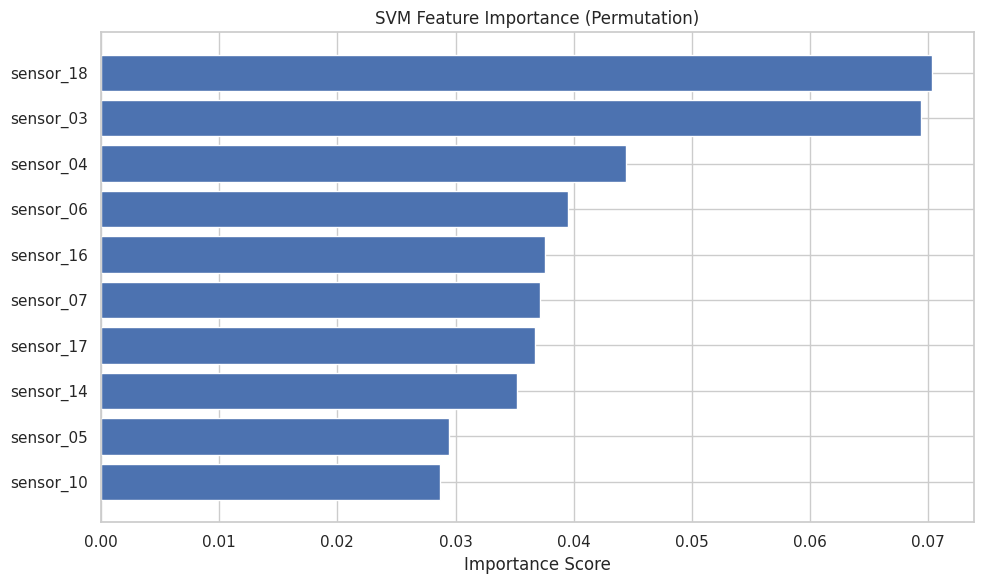

In [33]:
# SVM Feature Importance (using permutation importance)
from sklearn.inspection import permutation_importance

# Calculate permutation importance
perm_importance = permutation_importance(
    svm_model, X_test, y_test, n_repeats=10, random_state=42
)

# Create feature importance DataFrame
svm_importance_df = pd.DataFrame({
    'Feature': [f'sensor_{i:02d}' for i in range(X.shape[1])],
    'Importance': perm_importance.importances_mean
}).sort_values('Importance', ascending=False)

# Display top 10 features
print("Top 10 SVM Feature Importances:")
print(svm_importance_df.head(10).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(svm_importance_df['Feature'].head(10), svm_importance_df['Importance'].head(10))
plt.xlabel('Importance Score')
plt.title('SVM Feature Importance (Permutation)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

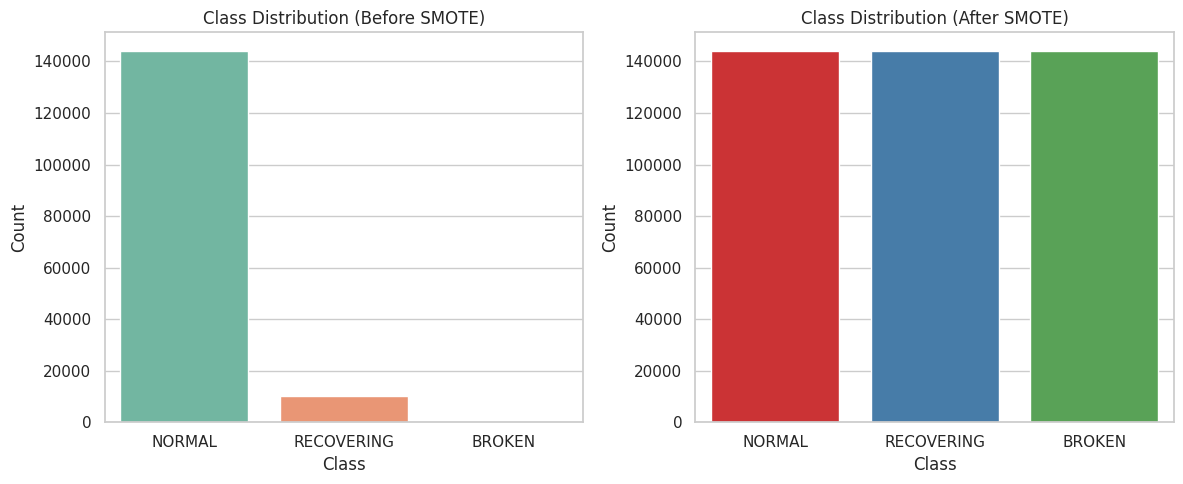

In [27]:
# Enhanced SMOTE visualization
plt.figure(figsize=(12, 5))

# Before SMOTE
plt.subplot(1, 2, 1)
sns.countplot(x=y_train_series, palette="Set2", order=y_train_series.value_counts().index)
plt.title("Class Distribution (Before SMOTE)")
plt.xlabel("Class")
plt.ylabel("Count")

# After SMOTE
plt.subplot(1, 2, 2)
sns.countplot(x=y_res_series, palette="Set1", order=y_res_series.value_counts().index)
plt.title("Class Distribution (After SMOTE)")
plt.xlabel("Class")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [28]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

# Initialize KNN
knn_model = KNeighborsClassifier(n_neighbors=5)

# Train on resampled data
knn_model.fit(X_train_res, y_train_res)

# Predict on test data
y_pred_knn = knn_model.predict(X_test)
y_pred_labels_knn = le.inverse_transform(y_pred_knn)

# Classification report
print("\nKNN Classification Report:")
print(classification_report(y_test_labels, y_pred_labels_knn))



KNN Classification Report:
              precision    recall  f1-score   support

      BROKEN       0.89      0.87      0.88       902
      NORMAL       0.96      0.93      0.95      1494
  RECOVERING       0.85      0.93      0.89       604

    accuracy                           0.92      3000
   macro avg       0.90      0.91      0.91      3000
weighted avg       0.92      0.92      0.92      3000



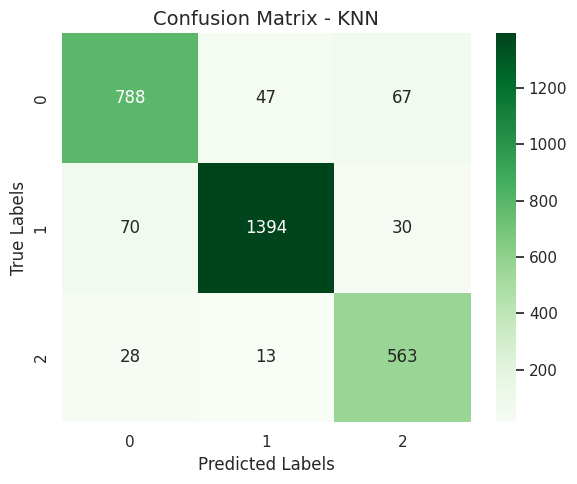

In [29]:
# Confusion Matrix for KNN
cm_knn = confusion_matrix(y_test_labels, y_pred_labels_knn)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - KNN", fontsize=14)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()

Top 10 KNN Feature Importances:
  Feature  Importance
sensor_18    0.061700
sensor_04    0.048867
sensor_03    0.045667
sensor_17    0.039633
sensor_05    0.035067
sensor_06    0.034067
sensor_10    0.032967
sensor_14    0.032467
sensor_07    0.031467
sensor_12    0.030800


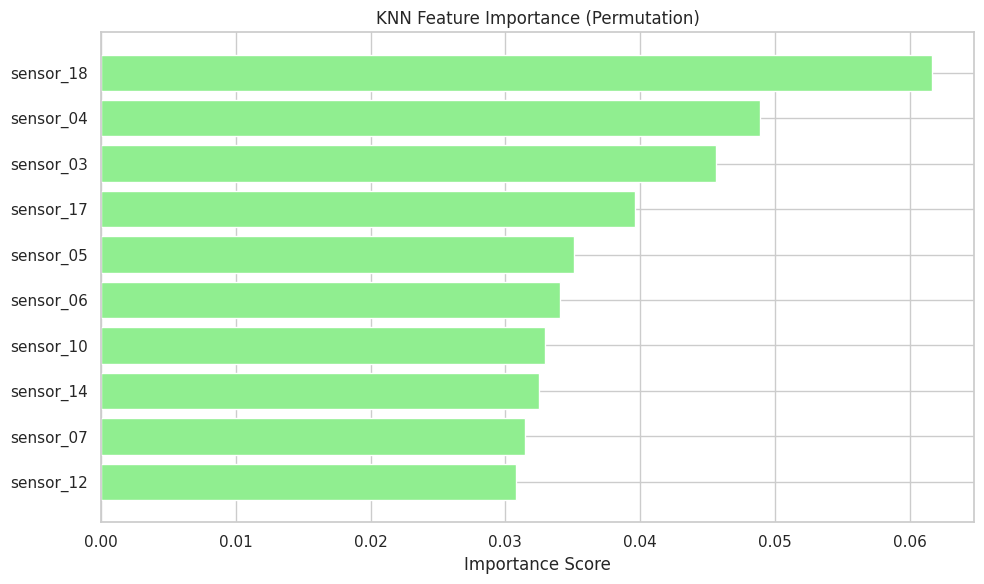

In [36]:
# KNN Feature Importance (using permutation importance)
from sklearn.inspection import permutation_importance

# Calculate permutation importance for KNN
perm_importance = permutation_importance(
    knn_model, X_test, y_test, n_repeats=10, random_state=42
)

# Create feature importance DataFrame
knn_importance_df = pd.DataFrame({
    'Feature': [f'sensor_{i:02d}' for i in range(X.shape[1])],
    'Importance': perm_importance.importances_mean
}).sort_values('Importance', ascending=False)

# Display top 10 features
print("Top 10 KNN Feature Importances:")
print(knn_importance_df.head(10).to_string(index=False))

# Plot feature importance with different color
plt.figure(figsize=(10, 6))
plt.barh(knn_importance_df['Feature'].head(10), knn_importance_df['Importance'].head(10), 
         color='lightgreen')
plt.xlabel('Importance Score')
plt.title('KNN Feature Importance (Permutation)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Initialize Logistic Regression
log_model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    class_weight='balanced',
    random_state=42
)

# Train on resampled data
log_model.fit(X_train_res, y_train_res)

# Predict on test data
y_pred_log = log_model.predict(X_test)
y_pred_labels_log = le.inverse_transform(y_pred_log)

# Classification report
print("\nLogistic Regression Classification Report:")
print(classification_report(y_test_labels, y_pred_labels_log))



Logistic Regression Classification Report:
              precision    recall  f1-score   support

      BROKEN       0.62      0.60      0.61       902
      NORMAL       0.77      0.70      0.73      1494
  RECOVERING       0.54      0.68      0.60       604

    accuracy                           0.66      3000
   macro avg       0.64      0.66      0.65      3000
weighted avg       0.68      0.66      0.67      3000



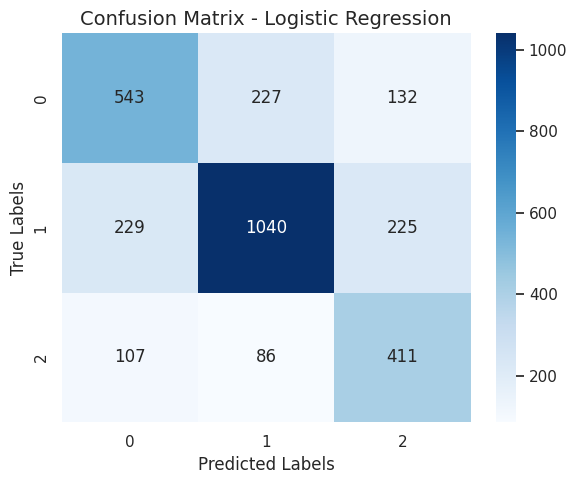

In [31]:
# Confusion Matrix for Logistic Regression
cm_log = confusion_matrix(y_test_labels, y_pred_labels_log)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression", fontsize=14)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()